# Оптимизация производственных расходов для металлургического комбинта "Стальная птица"

## Общая информация о проекте

### Описание этапов разработки

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

    data_arc_new.csv — данные об электродах;
    data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
    data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
    data_gas_new.csv — данные о продувке сплава газом;
    data_temp_new.csv — результаты измерения температуры;
    data_wire_new.csv — данные о проволочных материалах (объём);
    data_wire_time_new.csv — данные о проволочных материалах (время).

Файл data_arc_new.csv

    key — номер партии;
    Начало нагрева дугой — время начала нагрева;
    Конец нагрева дугой — время окончания нагрева;
    Активная мощность — значение активной мощности;
    Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.csv

    key — номер партии;
    Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv

    key — номер партии;
    Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv

    key — номер партии;
    Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv

    key — номер партии;
    Время замера — время замера;
    Температура — значение температуры.

Файл data_wire_new.csv

    key — номер партии;
    Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

Файл data_wire_time_new.csv

    key — номер партии;
    Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### План проекта

* Загрузка данных
* Исследовательский анализ и предобработка данных
* Обьединение данных
* Исследовательский анализ и предобработка данных объединённого датафрейма
* Подготовка данных
* Обучение моделей
* Выбор лучшей модели
* Общий вывод

## Инициализация констант и импорт библиотек

In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor)
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostRegressor

from typing import Literal

In [3]:
RANDOM_STATE = 20824
TEST_SIZE = .25

## Загрузка данных

### Загрузка

In [4]:
try: 
    data_arc = pd.read_csv('./datasets/data_arc_new.csv', parse_dates=[1, 2])
    data_bulk = pd.read_csv('./datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('./datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('./datasets/data_gas_new.csv')
    data_temp = pd.read_csv('./datasets/data_temp_new.csv', parse_dates=[1])
    data_wire = pd.read_csv('./datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('./datasets/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv', parse_dates=[1, 2])
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv', parse_dates=[1])
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

### data_arc

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


### data_bulk

In [8]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [9]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


### data_bulk_time

In [10]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [11]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


### data_gas

In [12]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [13]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


### data_temp

In [14]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [15]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


### data_wire

In [16]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### data_wire_time

In [18]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Изменение названий колонок

In [20]:
data_arc.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']

data_bulk.columns = data_bulk.columns.str.lower()
data_bulk.columns = data_bulk.columns.str.replace(' ', '_')

data_bulk_time.columns = data_bulk_time.columns.str.lower()
data_bulk_time.columns = data_bulk_time.columns.str.replace(' ', '_')

data_gas.columns = ['key', 'gas_1']

data_temp.columns = ['key', 'time', 'temperature']

data_wire.columns = data_wire.columns.str.lower()
data_wire.columns = data_wire.columns.str.replace(' ', '_')

data_wire_time.columns = data_wire_time.columns.str.lower()
data_wire_time.columns = data_wire_time.columns.str.replace(' ', '_')

### Выводы по разделу

* Заргужены таблицы data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_rime.
* Изменены названия колонок (приведены к змеиному регистру).
* В некоторых таблицах есть пропуски.
* Измерения времени имеют тип object, который следует изменить на datetime.
* Следует проверить таблицы на аномалии и выбросы.

## Предобработка и EDA 

### Вспомогательные функции

In [21]:
# Показывает количество и процент пропусков
def show_na(data: pd.DataFrame):
    report = data.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
    return report.sort_values(by = 'missing_values', ascending = False)

In [22]:
# Функция для удаления колонок, в которых больше 90% пропусков
def del_col(data: pd.DataFrame):
    for col in data.columns:
        if (data[col].isna().sum() / data.shape[0]).round(2) >= .5:
            data.drop(col, axis=1, inplace=True)

In [23]:
def to_datetime(data: pd.DataFrame, columns: list):
    for col in columns:
        if col != 'key':
            data[col] =  pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')

### Обработка пропусков

In [24]:
show_na(data_arc)

,missing_values,% of total
key,0,0.0
start_arc_heating,0,0.0
end_arc_heating,0,0.0
active_power,0,0.0
reactive_power,0,0.0


In [25]:
show_na(data_bulk)

,missing_values,% of total
bulk_8,3128,1.00
bulk_13,3111,0.99
bulk_9,3110,0.99
bulk_2,3107,0.99
bulk_7,3104,0.99
bulk_5,3052,0.98
bulk_10,2953,0.94
bulk_11,2952,0.94
bulk_1,2877,0.92
bulk_6,2553,0.82


In [26]:
del_col(data_bulk)
data_bulk.head()

,key,bulk_12,bulk_14,bulk_15
0,1,206.0,150.0,154.0
1,2,206.0,149.0,154.0
2,3,205.0,152.0,153.0
3,4,207.0,153.0,154.0
4,5,203.0,151.0,152.0


In [27]:
data_bulk = data_bulk.fillna(0)
data_bulk.head()

,key,bulk_12,bulk_14,bulk_15
0,1,206.0,150.0,154.0
1,2,206.0,149.0,154.0
2,3,205.0,152.0,153.0
3,4,207.0,153.0,154.0
4,5,203.0,151.0,152.0


In [28]:
show_na(data_bulk_time)

,missing_values,% of total
bulk_8,3128,1.00
bulk_13,3111,0.99
bulk_9,3110,0.99
bulk_2,3107,0.99
bulk_7,3104,0.99
bulk_5,3052,0.98
bulk_10,2953,0.94
bulk_11,2952,0.94
bulk_1,2877,0.92
bulk_6,2553,0.82


In [29]:
del_col(data_bulk_time)
data_bulk_time.head()

,key,bulk_12,bulk_14,bulk_15
0,1,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47


In [30]:
show_na(data_gas)

,missing_values,% of total
key,0,0.0
gas_1,0,0.0


In [31]:
show_na(data_temp)

,missing_values,% of total
temperature,3427,0.19
key,0,0.00
time,0,0.00


In [32]:
show_na(data_wire)

,missing_values,% of total
wire_5,3080,1.00
wire_7,3070,1.00
wire_4,3067,1.00
wire_8,3062,0.99
wire_9,3052,0.99
wire_3,3018,0.98
wire_6,3008,0.98
wire_2,2002,0.65
wire_1,26,0.01
key,0,0.00


In [33]:
del_col(data_wire)
data_wire.head()

,key,wire_1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236


In [34]:
data_wire.fillna(0, inplace=True)
data_wire.head()

,key,wire_1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236


In [35]:
show_na(data_wire_time)

,missing_values,% of total
wire_5,3080,1.00
wire_7,3070,1.00
wire_4,3067,1.00
wire_8,3062,0.99
wire_9,3052,0.99
wire_3,3018,0.98
wire_6,3008,0.98
wire_2,2002,0.65
wire_1,26,0.01
key,0,0.00


In [36]:
del_col(data_wire_time)
data_wire_time.head()

,key,wire_1
0,1,2019-05-03 11:06:19
1,2,2019-05-03 11:36:50
2,3,2019-05-03 12:11:46
3,4,2019-05-03 12:43:22
4,5,2019-05-03 13:20:44


#### Обработка целевого признака

In [37]:
data_temp.head(10)

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [38]:
data_temp = data_temp.fillna(0)

In [39]:
data_temp = data_temp.pivot_table(values=['temperature', 'time'], index='key', aggfunc=['first', 'last'])

In [40]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   (first, temperature)  3216 non-null   float64       
 1   (first, time)         3216 non-null   datetime64[ns]
 2   (last, temperature)   3216 non-null   float64       
 3   (last, time)          3216 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 125.6 KB


In [41]:
data_temp.columns = ['first_temperature', 'first_time', 'last_temperature', 'last_time']

In [42]:
data_temp.head()

,first_temperature,first_time,last_temperature,last_time
key,,,,
1,1571.0,2019-05-03 11:02:04,1613.0,2019-05-03 11:30:38
2,1581.0,2019-05-03 11:34:04,1602.0,2019-05-03 11:55:09
3,1596.0,2019-05-03 12:06:44,1599.0,2019-05-03 12:35:57
4,1601.0,2019-05-03 12:39:27,1625.0,2019-05-03 12:59:47
5,1576.0,2019-05-03 13:11:03,1602.0,2019-05-03 13:36:39


In [43]:
data_temp = data_temp[data_temp['last_temperature'] != 0]

In [44]:
data_temp.shape

(2477, 4)

In [45]:
data_temp['temp_duration'] = (data_temp['last_time'] - data_temp['first_time']).dt.seconds

In [46]:
data_temp.head()

,first_temperature,first_time,last_temperature,last_time,temp_duration
key,,,,,
1,1571.0,2019-05-03 11:02:04,1613.0,2019-05-03 11:30:38,1714
2,1581.0,2019-05-03 11:34:04,1602.0,2019-05-03 11:55:09,1265
3,1596.0,2019-05-03 12:06:44,1599.0,2019-05-03 12:35:57,1753
4,1601.0,2019-05-03 12:39:27,1625.0,2019-05-03 12:59:47,1220
5,1576.0,2019-05-03 13:11:03,1602.0,2019-05-03 13:36:39,1536


In [47]:
data_temp = data_temp[data_temp['temp_duration'] != 0]

In [48]:
data_temp.drop(['last_time', 'first_time'], axis=1, inplace=True)

#### Изменение типов данных

In [49]:
to_datetime(data_bulk_time, data_bulk_time.columns)
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_12  2450 non-null   datetime64[ns]
 2   bulk_14  2806 non-null   datetime64[ns]
 3   bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(1)
memory usage: 97.9 KB


In [50]:
to_datetime(data_wire_time, data_wire_time.columns)
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 48.3 KB


### EDA

In [51]:
all_data_arr = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [52]:
for el in all_data_arr:
    display(el.describe())

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


,key,bulk_12,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,203.948226,152.706616,115.319271
std,933.337642,151.419639,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000
25%,816.000000,105.000000,104.000000,0.000000
50%,1622.000000,206.000000,148.000000,106.000000
75%,2431.000000,263.000000,202.000000,204.000000
max,3241.000000,1849.000000,636.000000,405.000000


,key,bulk_12,bulk_14,bulk_15
count,3129.000000,2450,2806,2248
mean,1624.383509,2019-07-05 22:55:11.468571392,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-06-03 12:48:47.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-07-03 01:32:00,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-08-08 14:55:05.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-06 15:01:44,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN


,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,first_temperature,last_temperature,temp_duration
count,2475.000000,2475.000000,2475.000000
mean,1588.402020,1595.336162,2280.896566
std,29.243044,16.023153,1373.705572
min,1191.000000,1541.000000,339.000000
25%,1572.000000,1587.000000,1544.500000
50%,1588.000000,1593.000000,2009.000000
75%,1605.000000,1599.000000,2738.500000
max,1679.000000,1700.000000,23674.000000


,key,wire_1
count,3081.000000,3081.000000
mean,1623.426485,100.044411
std,932.996726,42.841120
min,1.000000,0.000000
25%,823.000000,70.281120
50%,1619.000000,100.114563
75%,2434.000000,125.798405
max,3241.000000,330.314424


,key,wire_1
count,3081.000000,3055
mean,1623.426485,2019-07-05 23:22:34.279541760
min,1.000000,2019-05-03 11:06:19
25%,823.000000,2019-06-04 19:30:11.500000
50%,1619.000000,2019-07-03 06:36:23
75%,2434.000000,2019-08-08 08:56:06.500000
max,3241.000000,2019-09-06 17:10:06
std,932.996726,NaN


Text(0.5, 1.0, 'Гистограмма active_power')

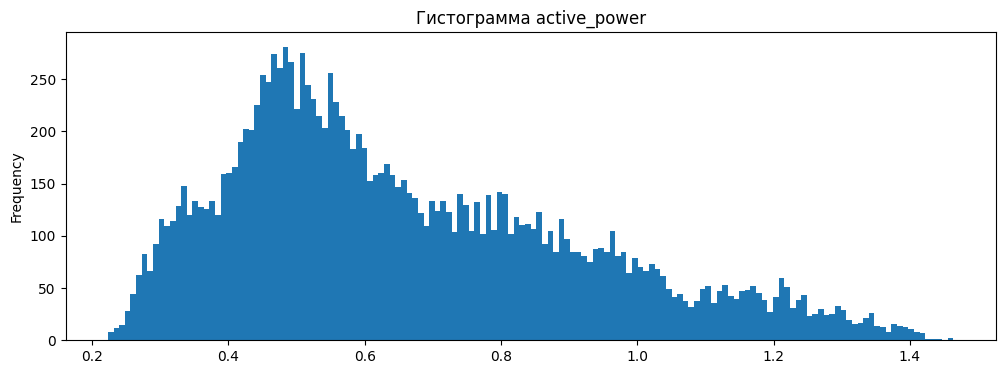

Text(0.5, 1.0, 'Диаграмма размаха active_power')

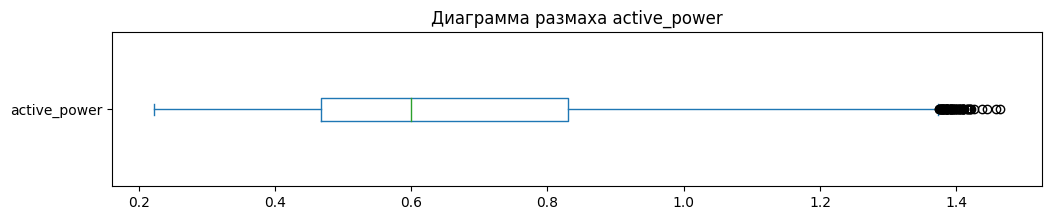

Text(0.5, 1.0, 'Гистограмма reactive_power')

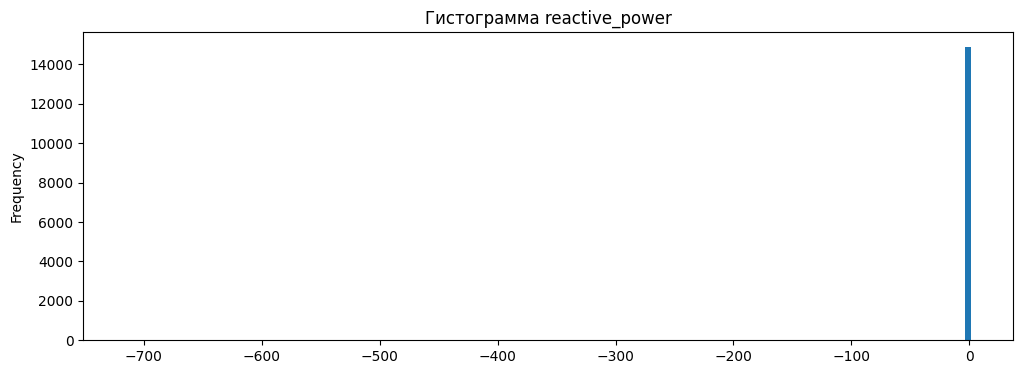

Text(0.5, 1.0, 'Диаграмма размаха reactive_power')

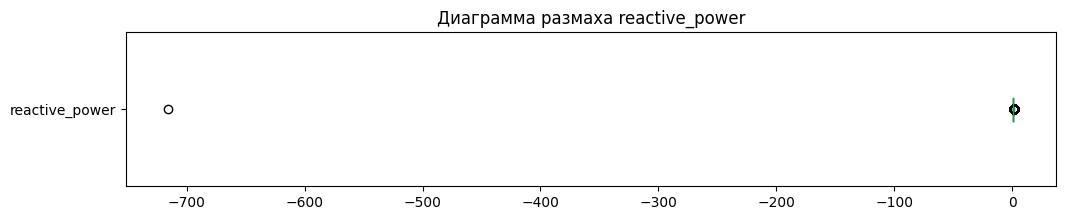

Text(0.5, 1.0, 'Гистограмма bulk_12')

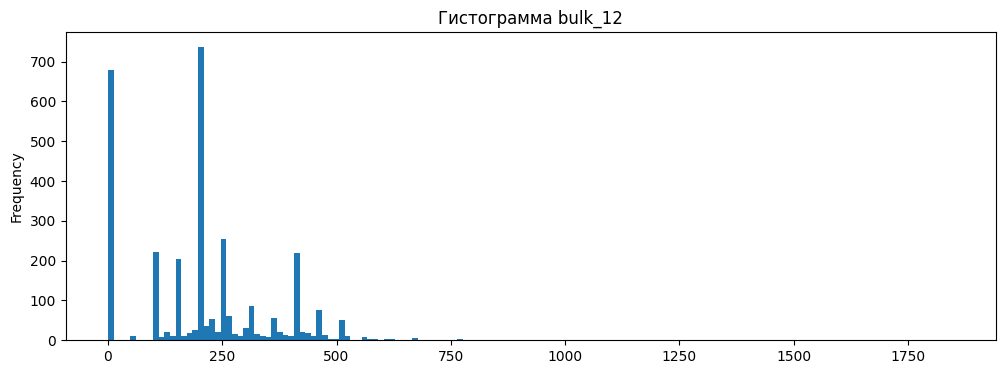

Text(0.5, 1.0, 'Диаграмма размаха bulk_12')

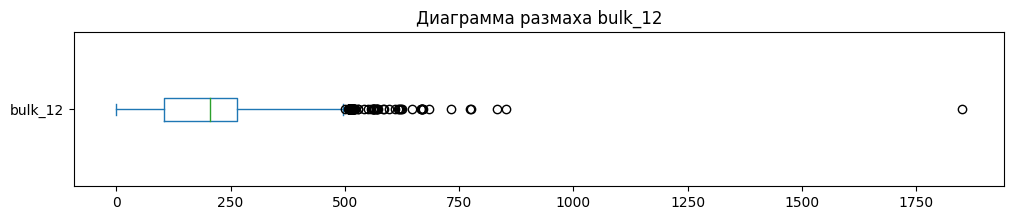

Text(0.5, 1.0, 'Гистограмма bulk_14')

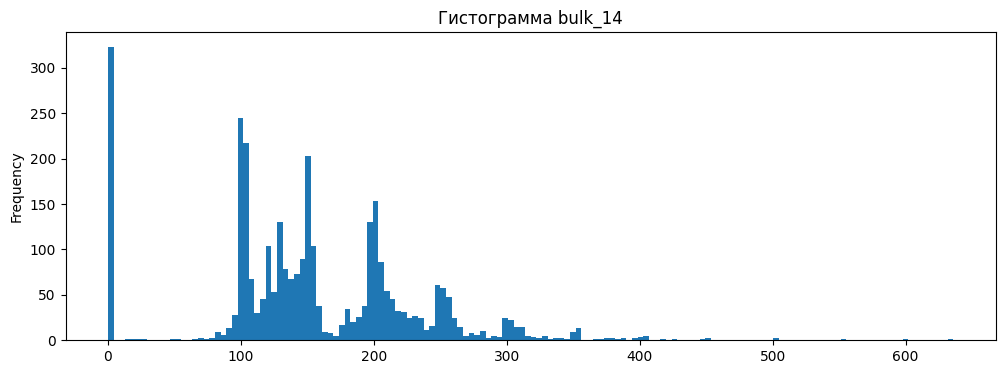

Text(0.5, 1.0, 'Диаграмма размаха bulk_14')

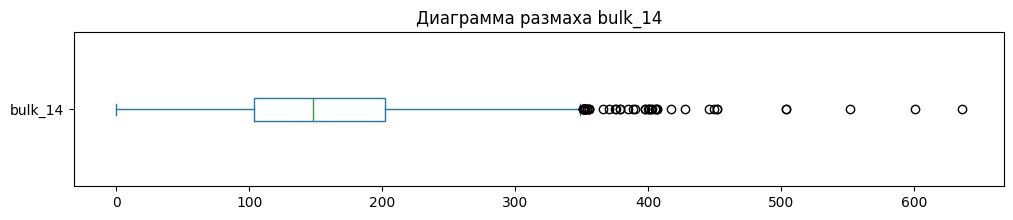

Text(0.5, 1.0, 'Гистограмма bulk_15')

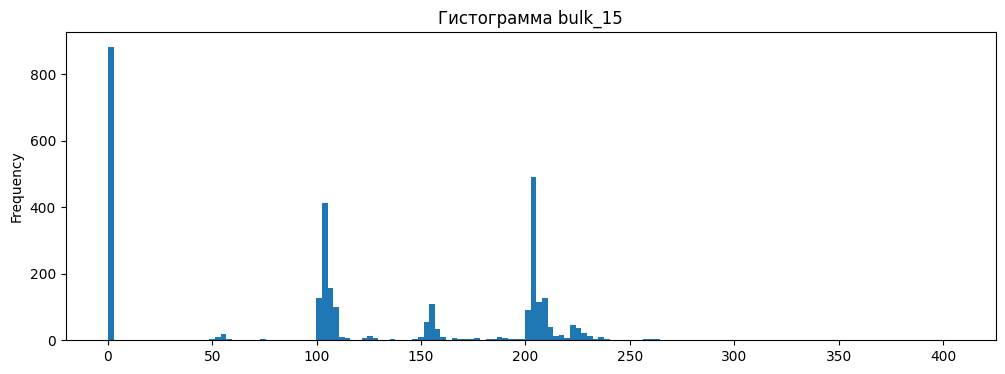

Text(0.5, 1.0, 'Диаграмма размаха bulk_15')

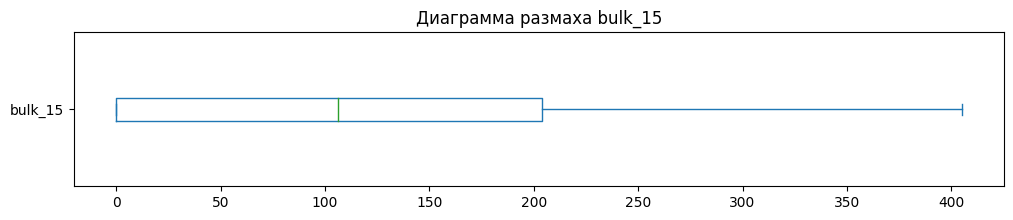

Text(0.5, 1.0, 'Гистограмма gas_1')

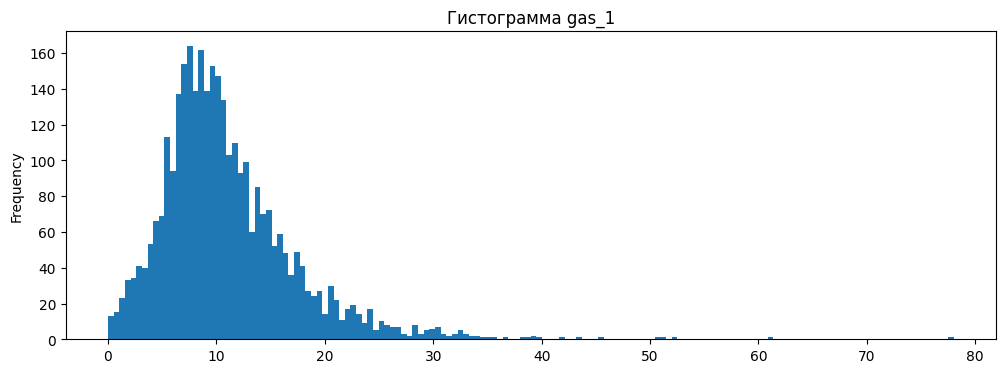

Text(0.5, 1.0, 'Диаграмма размаха gas_1')

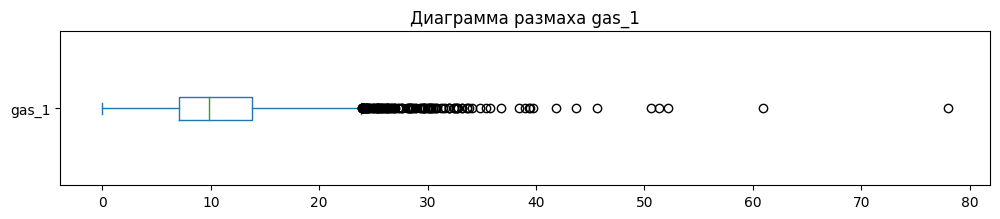

Text(0.5, 1.0, 'Гистограмма first_temperature')

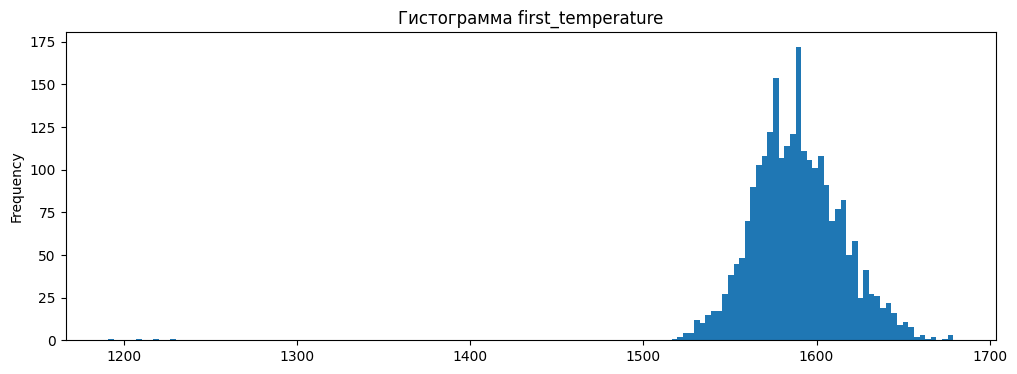

Text(0.5, 1.0, 'Диаграмма размаха first_temperature')

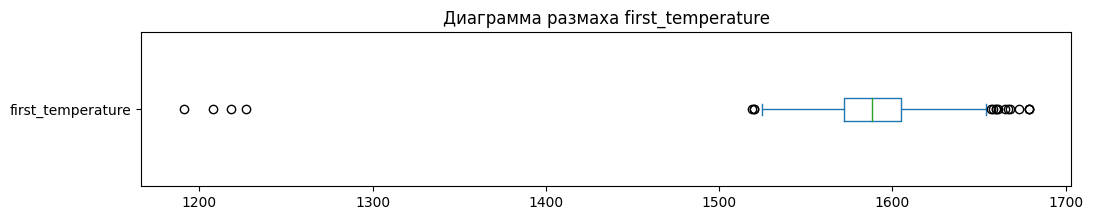

Text(0.5, 1.0, 'Гистограмма last_temperature')

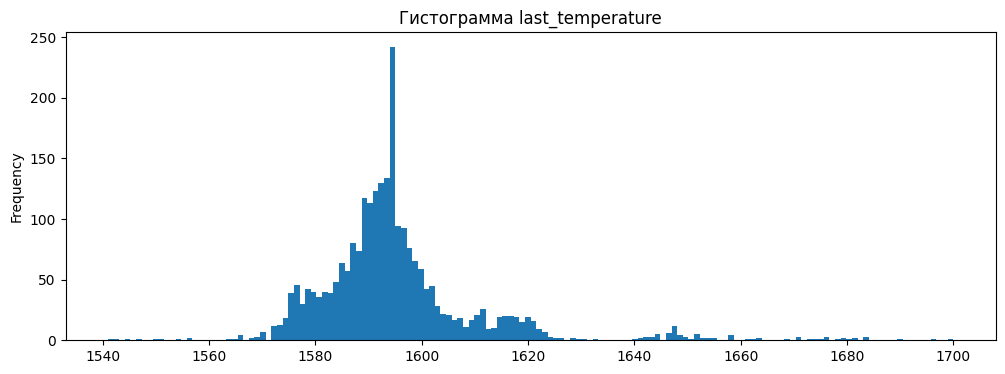

Text(0.5, 1.0, 'Диаграмма размаха last_temperature')

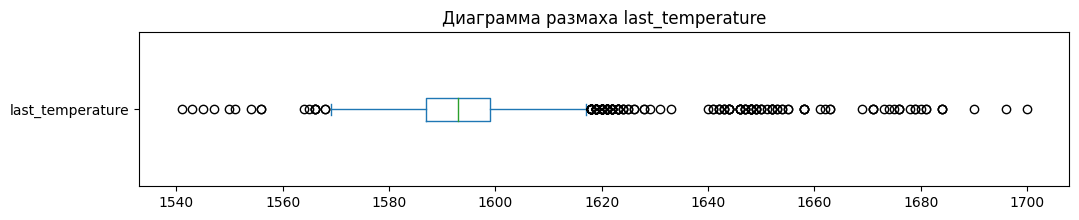

Text(0.5, 1.0, 'Гистограмма temp_duration')

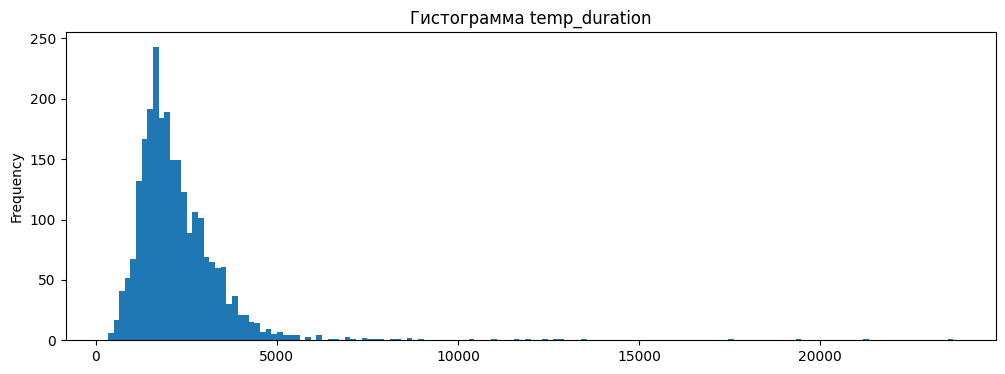

Text(0.5, 1.0, 'Диаграмма размаха temp_duration')

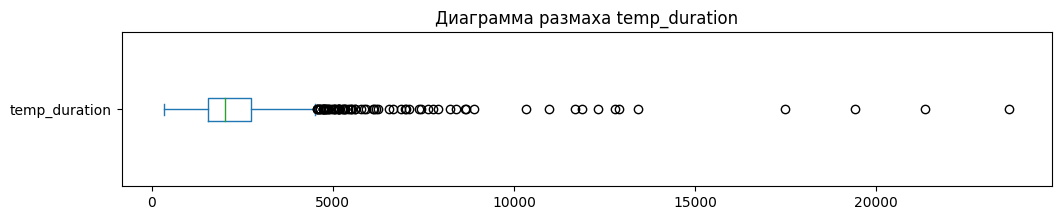

Text(0.5, 1.0, 'Гистограмма wire_1')

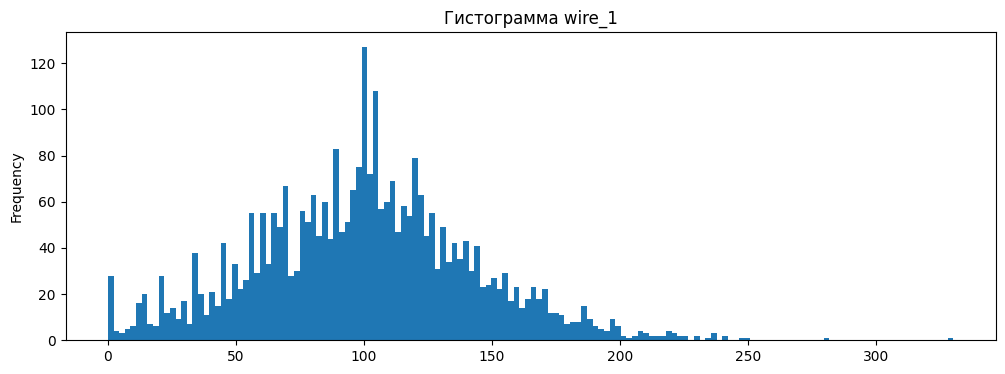

Text(0.5, 1.0, 'Диаграмма размаха wire_1')

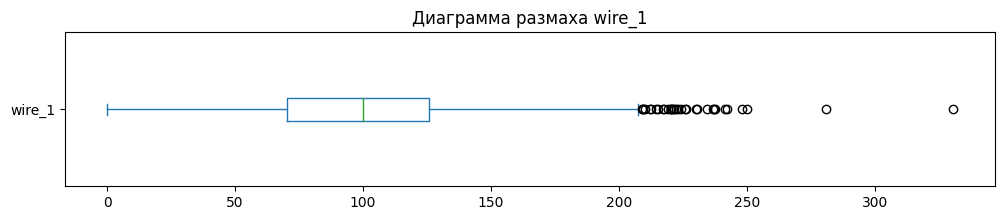

In [53]:
for el in all_data_arr:
    for col in el.columns:
        if (el[col].dtype == 'float64' or el[col].dtype == 'int64' or el[col].dtype == 'int32') and col != 'key':
            display(el[col].plot(kind='hist', bins=150, figsize=(12,4)).set_title(f'Гистограмма {col}'));
            plt.show()
            display(el[col].plot(kind='box', vert=False, figsize=(12,2)).set_title(f'Диаграмма размаха {col}'));
            plt.show()

#### Удаление аномалий

In [54]:
data_arc = data_arc[data_arc['reactive_power'] > 0]

Text(0.5, 1.0, 'Гистограмма reactive_power')

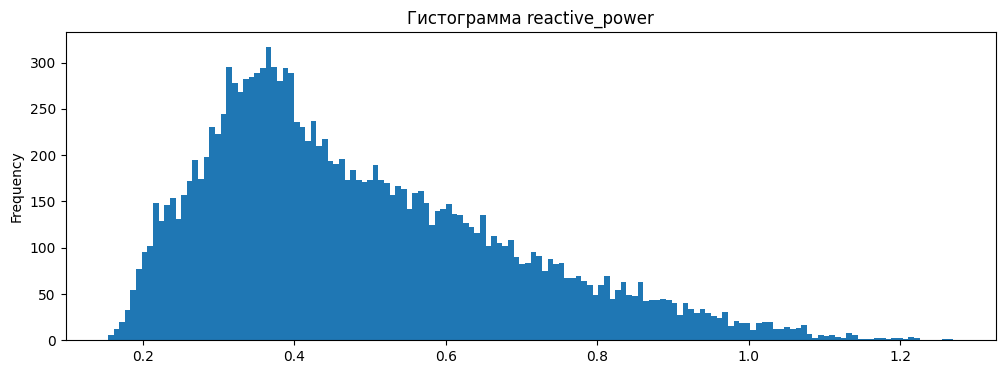

Text(0.5, 1.0, 'Диаграмма размаха reactive_power')

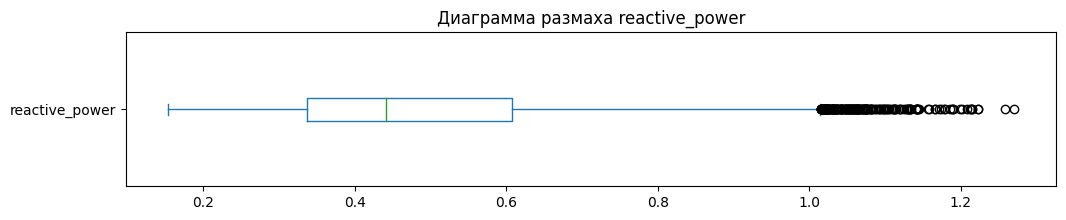

In [55]:
display(data_arc['reactive_power'].plot(kind='hist', bins=150, figsize=(12,4)).set_title(f'Гистограмма reactive_power'))
plt.show()
display(data_arc['reactive_power'].plot(kind='box', vert=False, figsize=(12,2)).set_title(f'Диаграмма размаха reactive_power'))
plt.show()

In [56]:
# Выходная энергия не может быть больше чем входная
data_arc = data_arc[data_arc['active_power'] - data_arc['reactive_power'] > 0]

In [57]:
data_temp = data_temp[(data_temp['last_temperature'] > 1400) & (data_temp['first_temperature'] > 1400)]

Text(0.5, 1.0, 'Гистограмма last_temperature')

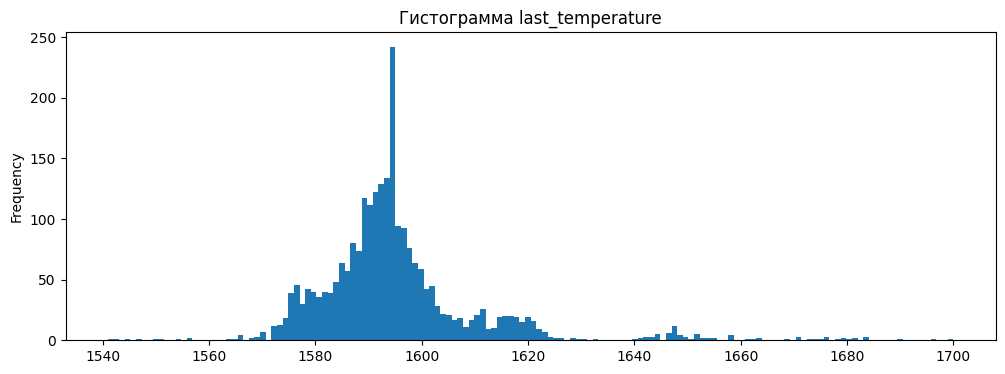

Text(0.5, 1.0, 'Диаграмма размаха last_temperature')

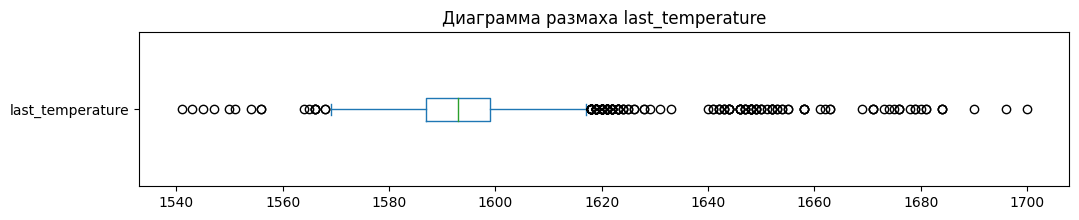

In [58]:
display(data_temp['last_temperature'].plot(kind='hist', bins=150, figsize=(12,4)).set_title(f'Гистограмма last_temperature'))
plt.show()
display(data_temp['last_temperature'].plot(kind='box', vert=False, figsize=(12,2)).set_title(f'Диаграмма размаха last_temperature'))
plt.show()

Text(0.5, 1.0, 'Гистограмма first_temperature')

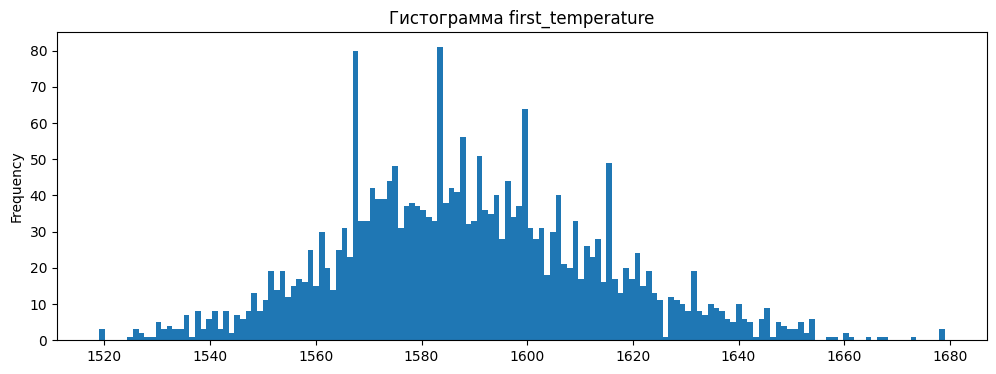

Text(0.5, 1.0, 'Диаграмма размаха first_temperature')

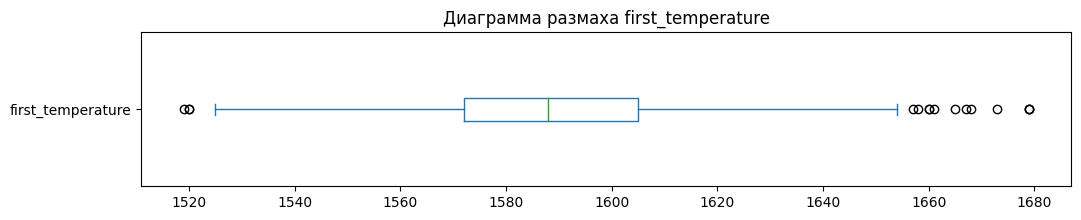

In [59]:
display(data_temp['first_temperature'].plot(kind='hist', bins=150, figsize=(12,4)).set_title(f'Гистограмма first_temperature'))
plt.show()
display(data_temp['first_temperature'].plot(kind='box', vert=False, figsize=(12,2)).set_title(f'Диаграмма размаха first_temperature'))
plt.show()

### Выводы по разделу

* Обработаны пропуски: 
    * колонки имеющие больше 50% пропусков удалены,
    * пропуски в числовых колонках заполнены нулями.
    * пропуски в целевом значении удалены.
* Изменены типы данных всех колонок, указывающих время, с object на datetime.
* Проведен исследовательский анализ, удалены аномалии в активной и реактивной мощностях и тепмературе.

* Следует обьединить некоторые таблицы в одну для обучения модели. 

## Обьединение таблиц

В итоговой таблице должны быть: температура в начале обработки и в конце, обьем каждой добавки в итерации, длительность итерации, обьем газа, активная и реактивная мощность, полная мощность, количество добавлений в итерации.

In [60]:
data_all = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc=['sum'])

In [61]:
data_all = data_all.join(data_arc.pivot_table(index='key', values=['active_power'], aggfunc=['count']).set_index(data_all.index), how='inner')
data_all = data_all.join(data_arc.pivot_table(index='key', values=['start_arc_heating', 'end_arc_heating'], aggfunc=['first', 'last']).set_index(data_all.index), how='inner')
data_all.head()

sum                       count               first  \
    active_power reactive_power active_power     end_arc_heating   
key                                                                
1       3.036730       2.142821            5 2019-05-03 11:06:02   
2       2.139408       1.453357            4 2019-05-03 11:36:31   
3       4.063641       2.937457            5 2019-05-03 12:11:34   
4       2.706489       2.056992            4 2019-05-03 12:43:04   
5       2.252950       1.687991            4 2019-05-03 13:15:24   

                                       last                      
      start_arc_heating     end_arc_heating   start_arc_heating  
key                                                              
1   2019-05-03 11:02:14 2019-05-03 11:28:37 2019-05-03 11:26:09  
2   2019-05-03 11:34:14 2019-05-03 11:53:18 2019-05-03 11:49:48  
3   2019-05-03 12:06:54 2019-05-03 12:32:19 2019-05-03 12:31:14  
4   2019-05-03 12:39:37 2019-05-03 12:57:50 2019-05-03 12:53:12  
5   2019-05-03 13:11:13 2019-05-03 13:33:55 2019-05-03 13:32:44

In [62]:
data_all.columns = ['active_power', 'reactive_power', 'iter_count', 'first_end_arc_heating', 'first_start_arc_heating', 'last_end_arc_heating', 'last_start_arc_heating']
data_all.head()

,active_power,reactive_power,iter_count,first_end_arc_heating,first_start_arc_heating,last_end_arc_heating,last_start_arc_heating
key,,,,,,,
1,3.036730,2.142821,5,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09
2,2.139408,1.453357,4,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48
3,4.063641,2.937457,5,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14
4,2.706489,2.056992,4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12
5,2.252950,1.687991,4,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44


In [63]:
data_all = data_all.join(data_bulk.set_index('key'), how='inner')
data_all.head()

,active_power,reactive_power,iter_count,first_end_arc_heating,first_start_arc_heating,last_end_arc_heating,last_start_arc_heating,bulk_12,bulk_14,bulk_15
key,,,,,,,,,,
1,3.036730,2.142821,5,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09,206.0,150.0,154.0
2,2.139408,1.453357,4,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48,206.0,149.0,154.0
3,4.063641,2.937457,5,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14,205.0,152.0,153.0
4,2.706489,2.056992,4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12,207.0,153.0,154.0
5,2.252950,1.687991,4,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44,203.0,151.0,152.0


In [64]:
data_all = data_all.join(data_gas.set_index('key'), how='inner')
data_all.head()

,active_power,reactive_power,iter_count,first_end_arc_heating,first_start_arc_heating,last_end_arc_heating,last_start_arc_heating,bulk_12,bulk_14,bulk_15,gas_1
key,,,,,,,,,,,
1,3.036730,2.142821,5,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09,206.0,150.0,154.0,29.749986
2,2.139408,1.453357,4,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48,206.0,149.0,154.0,12.555561
3,4.063641,2.937457,5,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14,205.0,152.0,153.0,28.554793
4,2.706489,2.056992,4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12,207.0,153.0,154.0,18.841219
5,2.252950,1.687991,4,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44,203.0,151.0,152.0,5.413692


In [65]:
data_all = data_all.join(data_wire.set_index('key'), how='inner', rsuffix='_wire')
data_all.head()

,active_power,reactive_power,iter_count,first_end_arc_heating,first_start_arc_heating,last_end_arc_heating,last_start_arc_heating,bulk_12,bulk_14,bulk_15,gas_1,wire_1
key,,,,,,,,,,,,
1,3.036730,2.142821,5,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09,206.0,150.0,154.0,29.749986,60.059998
2,2.139408,1.453357,4,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48,206.0,149.0,154.0,12.555561,96.052315
3,4.063641,2.937457,5,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14,205.0,152.0,153.0,28.554793,91.160157
4,2.706489,2.056992,4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12,207.0,153.0,154.0,18.841219,89.063515
5,2.252950,1.687991,4,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44,203.0,151.0,152.0,5.413692,89.238236


In [66]:
data_all = data_all.join(data_temp, how='inner')
data_all.head()

,active_power,reactive_power,iter_count,first_end_arc_heating,first_start_arc_heating,last_end_arc_heating,last_start_arc_heating,bulk_12,bulk_14,bulk_15,gas_1,wire_1,first_temperature,last_temperature,temp_duration
key,,,,,,,,,,,,,,,
1,3.036730,2.142821,5,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09,206.0,150.0,154.0,29.749986,60.059998,1571.0,1613.0,1714
2,2.139408,1.453357,4,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48,206.0,149.0,154.0,12.555561,96.052315,1581.0,1602.0,1265
3,4.063641,2.937457,5,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14,205.0,152.0,153.0,28.554793,91.160157,1596.0,1599.0,1753
4,2.706489,2.056992,4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12,207.0,153.0,154.0,18.841219,89.063515,1601.0,1625.0,1220
5,2.252950,1.687991,4,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44,203.0,151.0,152.0,5.413692,89.238236,1576.0,1602.0,1536


In [67]:
data_all['duration'] = (data_all['last_end_arc_heating'] - data_all['first_start_arc_heating']).dt.seconds
data_all.head()

,active_power,reactive_power,iter_count,first_end_arc_heating,first_start_arc_heating,last_end_arc_heating,last_start_arc_heating,bulk_12,bulk_14,bulk_15,gas_1,wire_1,first_temperature,last_temperature,temp_duration,duration
key,,,,,,,,,,,,,,,,
1,3.036730,2.142821,5,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09,206.0,150.0,154.0,29.749986,60.059998,1571.0,1613.0,1714,1583
2,2.139408,1.453357,4,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48,206.0,149.0,154.0,12.555561,96.052315,1581.0,1602.0,1265,1144
3,4.063641,2.937457,5,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14,205.0,152.0,153.0,28.554793,91.160157,1596.0,1599.0,1753,1525
4,2.706489,2.056992,4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12,207.0,153.0,154.0,18.841219,89.063515,1601.0,1625.0,1220,1093
5,2.252950,1.687991,4,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44,203.0,151.0,152.0,5.413692,89.238236,1576.0,1602.0,1536,1362


In [68]:
data_all.drop(['first_end_arc_heating', 'first_start_arc_heating', 'last_end_arc_heating', 'last_start_arc_heating'],axis=1 ,inplace=True)
data_all.head()

,active_power,reactive_power,iter_count,bulk_12,bulk_14,bulk_15,gas_1,wire_1,first_temperature,last_temperature,temp_duration,duration
key,,,,,,,,,,,,
1,3.036730,2.142821,5,206.0,150.0,154.0,29.749986,60.059998,1571.0,1613.0,1714,1583
2,2.139408,1.453357,4,206.0,149.0,154.0,12.555561,96.052315,1581.0,1602.0,1265,1144
3,4.063641,2.937457,5,205.0,152.0,153.0,28.554793,91.160157,1596.0,1599.0,1753,1525
4,2.706489,2.056992,4,207.0,153.0,154.0,18.841219,89.063515,1601.0,1625.0,1220,1093
5,2.252950,1.687991,4,203.0,151.0,152.0,5.413692,89.238236,1576.0,1602.0,1536,1362


In [69]:
data_all["energy_used"] = (data_all['active_power'] * data_all['active_power'] + data_all['reactive_power'] * data_all['reactive_power']) ** .5
# data_all.drop(['active_power', 'reactive_power'] ,axis=1, inplace=True)
data_all.head()

,active_power,reactive_power,iter_count,bulk_12,bulk_14,bulk_15,gas_1,wire_1,first_temperature,last_temperature,temp_duration,duration,energy_used
key,,,,,,,,,,,,,
1,3.036730,2.142821,5,206.0,150.0,154.0,29.749986,60.059998,1571.0,1613.0,1714,1583,3.716640
2,2.139408,1.453357,4,206.0,149.0,154.0,12.555561,96.052315,1581.0,1602.0,1265,1144,2.586371
3,4.063641,2.937457,5,205.0,152.0,153.0,28.554793,91.160157,1596.0,1599.0,1753,1525,5.014163
4,2.706489,2.056992,4,207.0,153.0,154.0,18.841219,89.063515,1601.0,1625.0,1220,1093,3.399456
5,2.252950,1.687991,4,203.0,151.0,152.0,5.413692,89.238236,1576.0,1602.0,1536,1362,2.815155


### Вывод по разделу

* Были получены следующие признаки: обьем газа за итерацию, начальная температура итерации, конечная температура итерации, продолжительность итерации, добавки в сплав и израсходованная энергия. 
* Целевым признаком является конечная температура итерации.

* Нужно проверить корреляцию полученных колонок между собой.
* Для обучения неодходимо разбить полученные данные на признаки и целевой признак и на тестовую и тренировочныю выборки.

## EDA и предобработка для итоговой таблицы

### Заполнение пропусков итоговой таблицы

In [70]:
show_na(data_all)

,missing_values,% of total
active_power,0,0.0
reactive_power,0,0.0
iter_count,0,0.0
bulk_12,0,0.0
bulk_14,0,0.0
bulk_15,0,0.0
gas_1,0,0.0
wire_1,0,0.0
first_temperature,0,0.0
last_temperature,0,0.0


In [71]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2325 entries, 1 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2325 non-null   float64
 1   reactive_power     2325 non-null   float64
 2   iter_count         2325 non-null   int64  
 3   bulk_12            2325 non-null   float64
 4   bulk_14            2325 non-null   float64
 5   bulk_15            2325 non-null   float64
 6   gas_1              2325 non-null   float64
 7   wire_1             2325 non-null   float64
 8   first_temperature  2325 non-null   float64
 9   last_temperature   2325 non-null   float64
 10  temp_duration      2325 non-null   int32  
 11  duration           2325 non-null   int32  
 12  energy_used        2325 non-null   float64
dtypes: float64(10), int32(2), int64(1)
memory usage: 236.1 KB


### EDA

In [72]:
data_all.describe()

,active_power,reactive_power,iter_count,bulk_12,bulk_14,bulk_15,gas_1,wire_1,first_temperature,last_temperature,temp_duration,duration,energy_used
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,3.125813,2.300941,4.695914,208.507957,153.971613,120.026667,11.378942,102.412198,1587.365161,1593.366022,2323.419785,1992.881290,3.882376
std,1.220473,0.903664,1.606250,157.137873,81.398153,84.674380,6.395632,43.535263,23.623144,11.209581,1385.569302,1351.016648,1.516031
min,0.267676,0.196228,1.000000,0.000000,0.000000,0.000000,0.008399,0.000000,1519.000000,1541.000000,339.000000,57.000000,0.331897
25%,2.295820,1.670519,4.000000,105.000000,105.000000,0.000000,7.282948,73.207679,1571.000000,1587.000000,1581.000000,1324.000000,2.841651
50%,3.036303,2.225398,5.000000,206.000000,149.000000,107.000000,10.100950,101.087998,1587.000000,1593.000000,2046.000000,1744.000000,3.767272
75%,3.834300,2.829159,6.000000,283.000000,204.000000,204.000000,14.217691,128.069763,1603.000000,1598.000000,2793.000000,2397.000000,4.767256
max,12.375636,8.949049,16.000000,1849.000000,636.000000,405.000000,77.995040,330.314424,1660.000000,1653.000000,23674.000000,23485.000000,15.272257


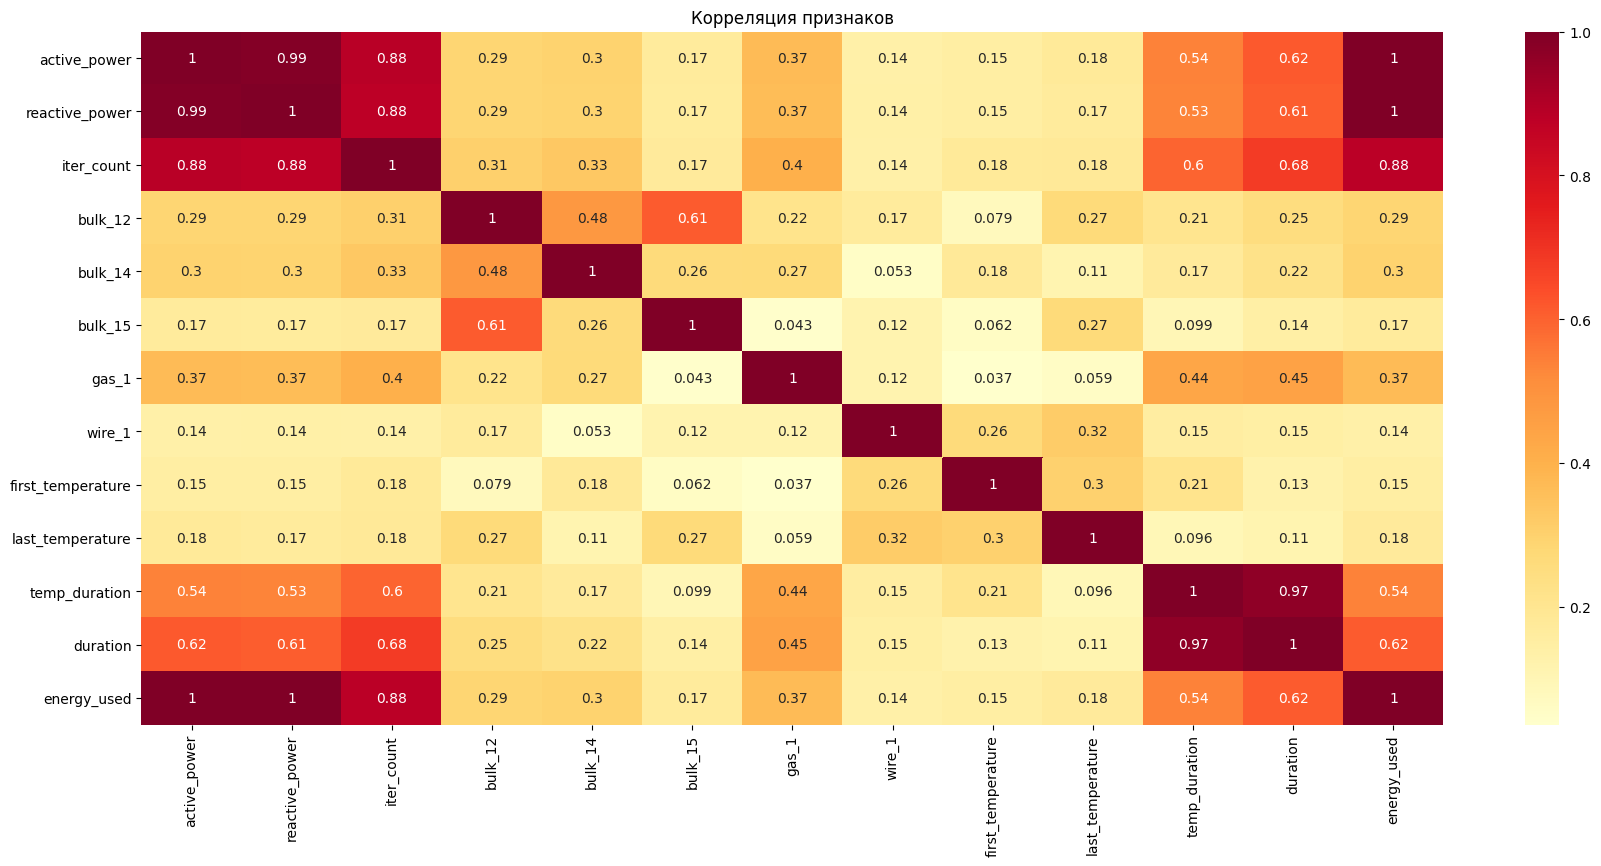

In [73]:
plt.figure(figsize=(21,9))
sns.heatmap(data_all.corr().abs(), cmap='YlOrRd', annot=True)
plt.title('Корреляция признаков')
plt.show()

Прослеживаются корреляции между active_power/reactive_pover/iter_count/temp_duration/duration/energy_used

In [74]:
data_all.head()

,active_power,reactive_power,iter_count,bulk_12,bulk_14,bulk_15,gas_1,wire_1,first_temperature,last_temperature,temp_duration,duration,energy_used
key,,,,,,,,,,,,,
1,3.036730,2.142821,5,206.0,150.0,154.0,29.749986,60.059998,1571.0,1613.0,1714,1583,3.716640
2,2.139408,1.453357,4,206.0,149.0,154.0,12.555561,96.052315,1581.0,1602.0,1265,1144,2.586371
3,4.063641,2.937457,5,205.0,152.0,153.0,28.554793,91.160157,1596.0,1599.0,1753,1525,5.014163
4,2.706489,2.056992,4,207.0,153.0,154.0,18.841219,89.063515,1601.0,1625.0,1220,1093,3.399456
5,2.252950,1.687991,4,203.0,151.0,152.0,5.413692,89.238236,1576.0,1602.0,1536,1362,2.815155


### Препобработка

Исходя из эксперементальных данный меняем датафрейм

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [76]:
data_all.drop('energy_used', axis=1, inplace=True)
data_all.drop('reactive_power', axis=1, inplace=True)
data_all.drop('iter_count', axis=1, inplace=True)
data_all.drop('temp_duration', axis=1, inplace=True)
# data_all.drop('bulk_15', axis=1, inplace=True)

Разбиваем данные для обучения и теста и масшабируем их

In [77]:
features = data_all.drop('last_temperature', axis=1)
target = data_all['last_temperature']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [79]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Выводы по разделу

* Проведен корреляционный анализ полученной таблицы.
* Данные разбиты на тренировочную и тестовую выборки.

* Можно приступать к обучению моделей.

## Обучение моделей 

### Вспомогательный класс для работы с моделями

In [99]:
class MultiModelLearning:
    def __init__(self, model_name: Literal['linear', 'tree', 'bagging', 'boosting', 'dummy', 'forest']):
        self.model_name = model_name
        if model_name == 'linear':
            self.model = LinearRegression()
        elif model_name == 'tree':
            self.model = DecisionTreeRegressor()
        elif model_name == 'bagging':
            self.model = BaggingRegressor()
        elif model_name == 'boosting':
            self.model = CatBoostRegressor()
        elif model_name == 'dummy':
            self.model = DummyRegressor(strategy="mean")
        elif model_name == 'forest':
            self.model = RandomForestRegressor()
        else:
            display("Было введено неверное имя модели")
        self.features = None
        self.target = None
        self.best_model = None
        self.best_score = None
        self.best_params = None
        self.results = None

    # Подбор гиперпараметров для модели
    def select_hyperparameters__(self, param_dist):
        grid_search = GridSearchCV(self.model, param_grid=param_dist, scoring='neg_mean_squared_error')
        grid_search.fit(self.features, self.target)
        self.best_model = grid_search.best_estimator_
        self.hyperparameters = grid_search.best_params_
        self.best_score = mean_absolute_error(grid_search.predict(self.features), self.target)
        self.results = grid_search.cv_results_

    # Функции обучения моделей
    def learn_linear_regression__(self): 
        param_dist = {
            'fit_intercept': [True, False]
        }
        self.select_hyperparameters__(param_dist)

    def learn_forest__(self): 
        param_dist = {
            'max_depth': [1, 3, 9, 18],
            'n_estimators': [10, 30, 60, 90],
            'min_samples_split': [2, 4, 6, 8],
            'random_state': [RANDOM_STATE]
        }
        self.select_hyperparameters__(param_dist)
    
    def learn_tree__(self):
        param_dist = {
            'max_depth': [i for i in range(1, 20)],
            'random_state': [RANDOM_STATE]
        }
        self.select_hyperparameters__(param_dist)

    def learn_bagging__(self):
        param_dist = {
            'n_estimators': [i for i in range(1, 8)],
            'random_state': [RANDOM_STATE]
        }
        self.select_hyperparameters__(param_dist)
        
    def learn_boosting__(self):
        param_dist = {
            'depth': [i for i in range(1, 8)],
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [1, .1, .01, .03, .001,],
            'random_state': [RANDOM_STATE],
            'loss_function': ['MAE'],
            'verbose': [False]
        }
        self.select_hyperparameters__(param_dist)

    def learn_dummy__(self):
        self.best_model = self.model.fit(self.features, self.target)
        self.best_score = -sum(cross_val_score(self.model, self.features, self.target, scoring='neg_mean_absolute_error'))/5



    def select_model__(self):
        if self.model_name == 'linear':
            self.learn_linear_regression__()
        elif self.model_name == 'tree':
            self.learn_tree__()
        elif self.model_name == 'bagging':
            self.learn_bagging__()
        elif self.model_name == 'boosting':
            self.learn_boosting__()
        elif self.model_name == 'dummy':
            self.learn_dummy__()
        elif self.model_name == 'ANN':
            self.learn_ANN__()
        elif self.model_name == 'forest':
            self.learn_forest__()
        else:
            display("Было введено неверное имя модели")

    def fit(self, features, target):
        self.features = features
        self.target = target
        self.select_model__()
    

    # Предсказание модели
    def predict(self, features):
        model_predictions = self.best_model.predict(features)
        return model_predictions

### Обучение моделей

In [81]:
dummy = MultiModelLearning('dummy')
dummy.fit(X_train, y_train)
dummy.best_score

8.143214127965248

In [100]:
linear = MultiModelLearning('linear')
linear.fit(X_train, y_train)
linear.best_score

7.3740485586099656

In [101]:
tree = MultiModelLearning('tree')
tree.fit(X_train, y_train)
tree.best_score

6.773894232904261

In [102]:
bagging = MultiModelLearning('bagging')
bagging.fit(X_train, y_train)
bagging.best_score

3.0535202032620274

In [103]:
forest = MultiModelLearning('forest')
forest.fit(X_train, y_train)
forest.best_score

5.130693874669115

In [104]:
boosting = MultiModelLearning('boosting')
boosting.fit(X_train, y_train)
boosting.best_score

4.977408377345726

### Информация о лучшей модели

In [87]:
boosting.best_model.feature_importances_

array([10.09504961, 10.62303291, 10.59438735,  7.08892358,  8.58590906,
       17.78305351, 18.74943785, 16.48020612])

In [88]:
boosting.hyperparameters

{'depth': 4,
 'learning_rate': 0.1,
 'loss_function': 'MAE',
 'n_estimators': 500,
 'random_state': 20824,
 'verbose': False}

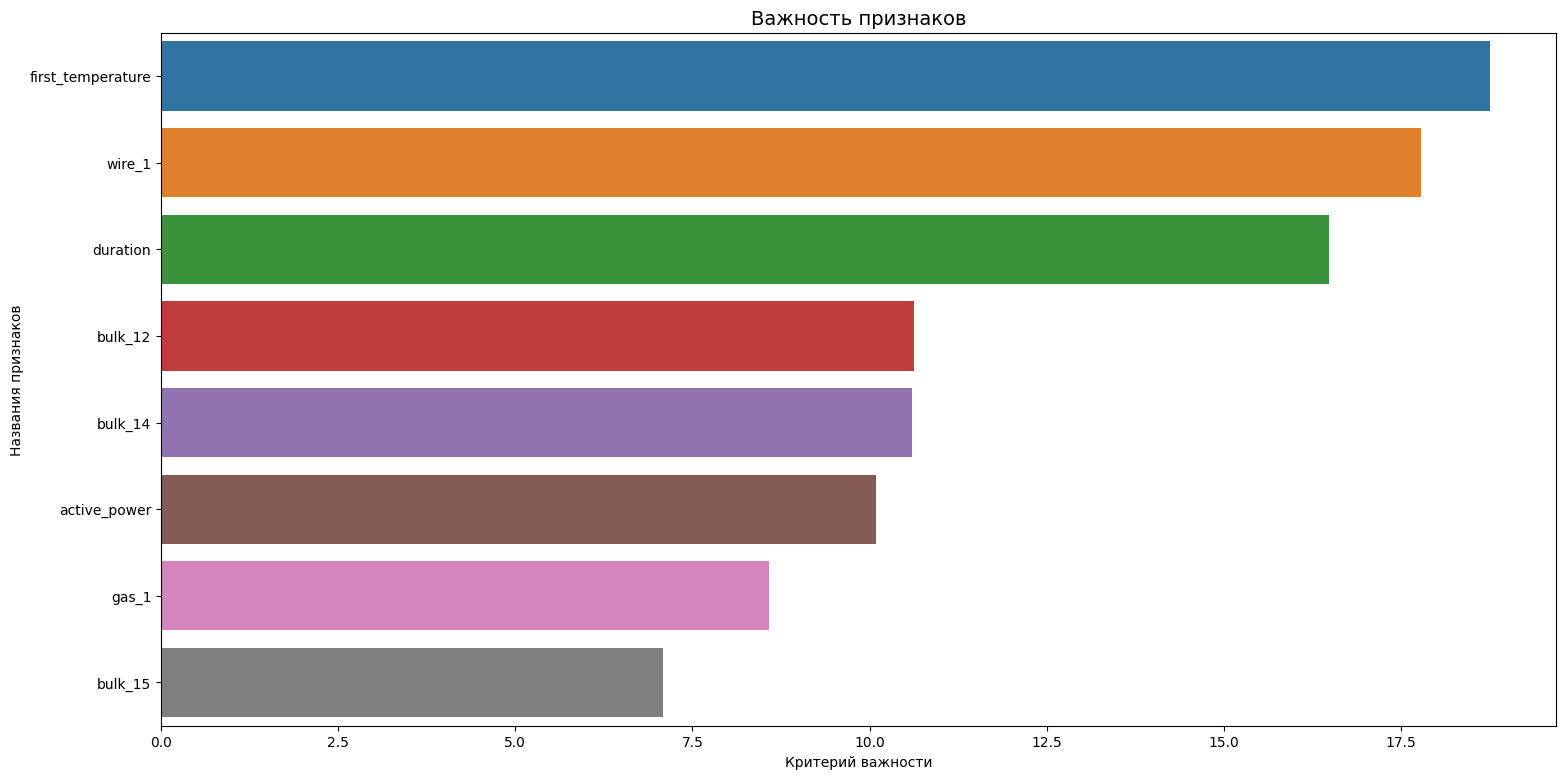

In [89]:
plot_data = {
    'features': features.columns,
    'feature_importances': boosting.best_model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

### Выводы по обучению

* Были обучены несколько моделей: линейная регрессия, дерево решений, случайный лес и бустинг.
* Лучшее качество показал бусинг с показателем mae 7.07.
* Гиперпараметры лучшей модели: {'depth': 4, 'learning_rate': 0.1, 'loss_function': 'MAE', 'n_estimators': 300, 'random_state': 20824}.
* Проверим качество лучшей модели на тестовой выборке.

## Тестирование лучшей модели

In [98]:
mean_absolute_error(boosting.predict(X_test), y_test)

6.550410676343728

* Качество бустинга на тестовой выборке составляет 6.6 что меньше чем 6.8 и удовлетворяет условиям заказчика.

## Общий вывод

* Предобработка и анализ данных:
    * Обработаны пропуски: 
        * колонки имеющие больше 50% пропусков удалены,
        * пропуски в числовых колонках заполнены нулями.
        * пропуски в целевом значении удалены.
    * Изменены типы данных всех колонок, указывающих время, с object на datetime.
    * Проведен исследовательский анализ, удалены аномалии в активной и реактивной мощностях и тепмературе.
* Обьединение данных в итоговую таблицу:
    * В итоговой таблице оставлены: температура в начале обработки и в конце, обьем каждой добавки в итерации, длительность итерации, обьем газа, активная мощность.
* Обучение моделей:
    * Были обучены несколько моделей: линейная регрессия, дерево решений, случайный лес и бустинг.
    * Лучшее качество показал бусинг с показателем mae 7.07.
    * Гиперпараметры лучшей модели: {'depth': 4, 'learning_rate': 0.1, 'loss_function': 'MAE', 'n_estimators': 300, 'random_state': 20824}.
    * Качество бустинга на тестовой выборке составляет 6.6 что меньше чем 6.8 и удовлетворяет условиям заказчика.
* Рекомендации по улучшению решения:
    * Увеличив выборку можно повысить качество моделей.
    * Возможно более тщательный подбор гиперпараметров моделей также может улучшить итоговое решений.